In [1]:
import warnings
warnings.filterwarnings('ignore')

### **Libraries Import**

In [2]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from utils import check_directory, plot_history, plot_random_batch_images, display_and_predict

### **Dataset Directories**

In [3]:
train_dir = 'dataset/train'
valid_dir = 'dataset/valid'
test_dir = 'dataset/test'

check_directory(train_dir)
check_directory(valid_dir)
check_directory(test_dir)

SUCCESS: The directory exists and contains 3 items.
	Example items (first level):
	- banh_cuon
	- banh_mi
	- pho
SUCCESS: The directory exists and contains 3 items.
	Example items (first level):
	- banh_cuon
	- banh_mi
	- pho
SUCCESS: The directory exists and contains 3 items.
	Example items (first level):
	- banh_cuon
	- banh_mi
	- pho


True

### **Data Augmentation**

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.2, 0.2),
        shear=0.2,
        scale=(0.8, 1.2)
    ),
    transforms.ToTensor()
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [5]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

### **Data Loaders**

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
classes = train_dataset.classes
print("Total classes:", len(classes))
print("Classes detected:", classes)

Total classes: 3
Classes detected: ['banh_cuon', 'banh_mi', 'pho']


### **Plot Training/Validating/Testing Images**

Displaying 9 random images...


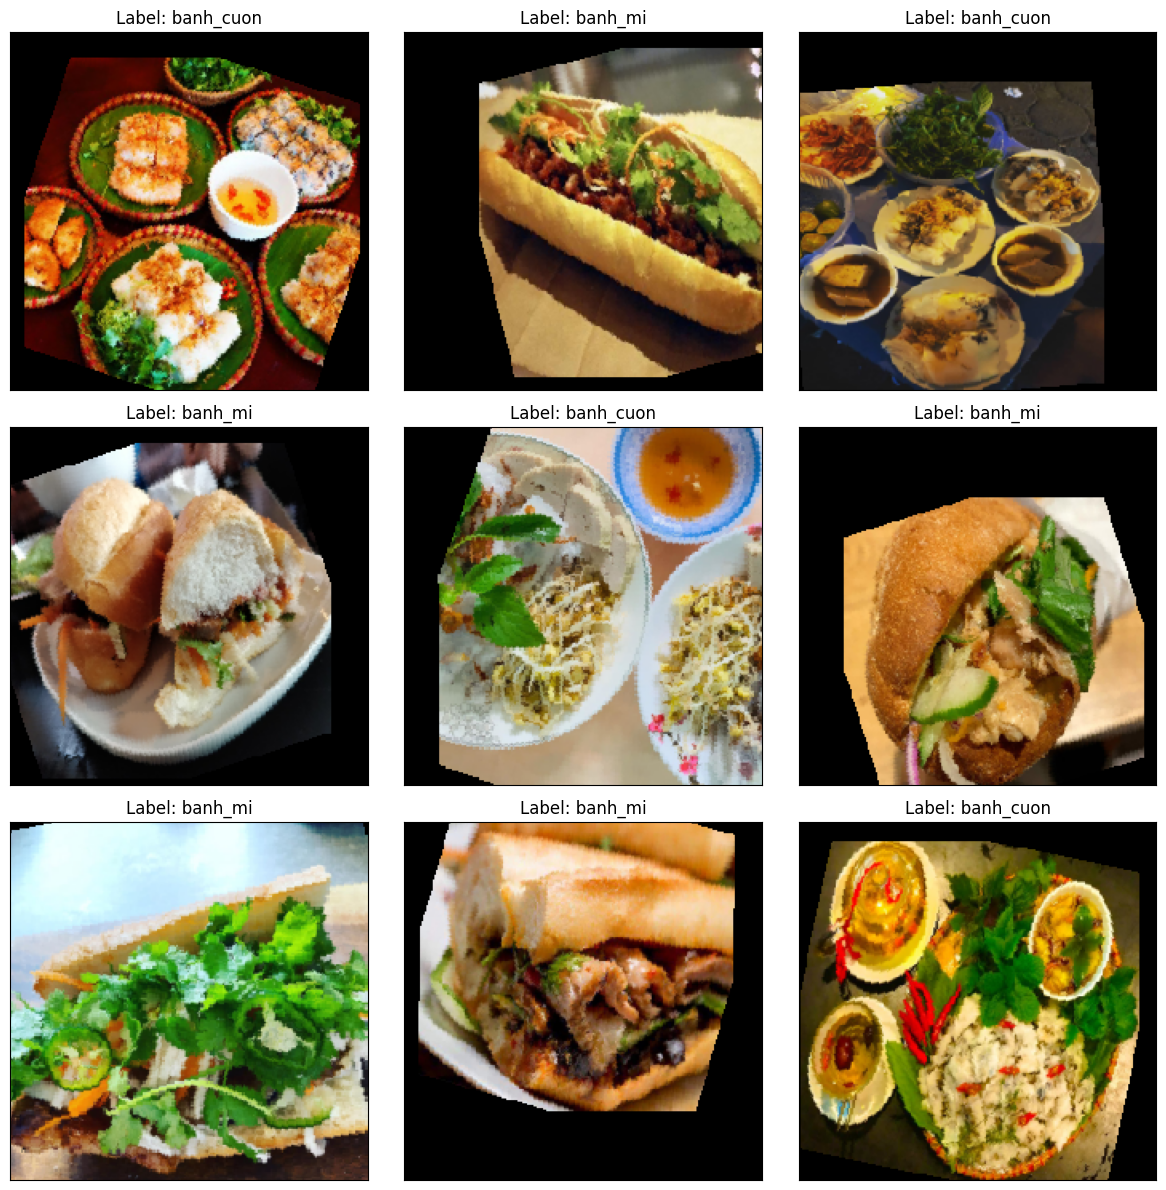

In [8]:
plot_random_batch_images(train_loader, classes, num_images_to_show=9, figsize=(12, 12))

Displaying 9 random images...


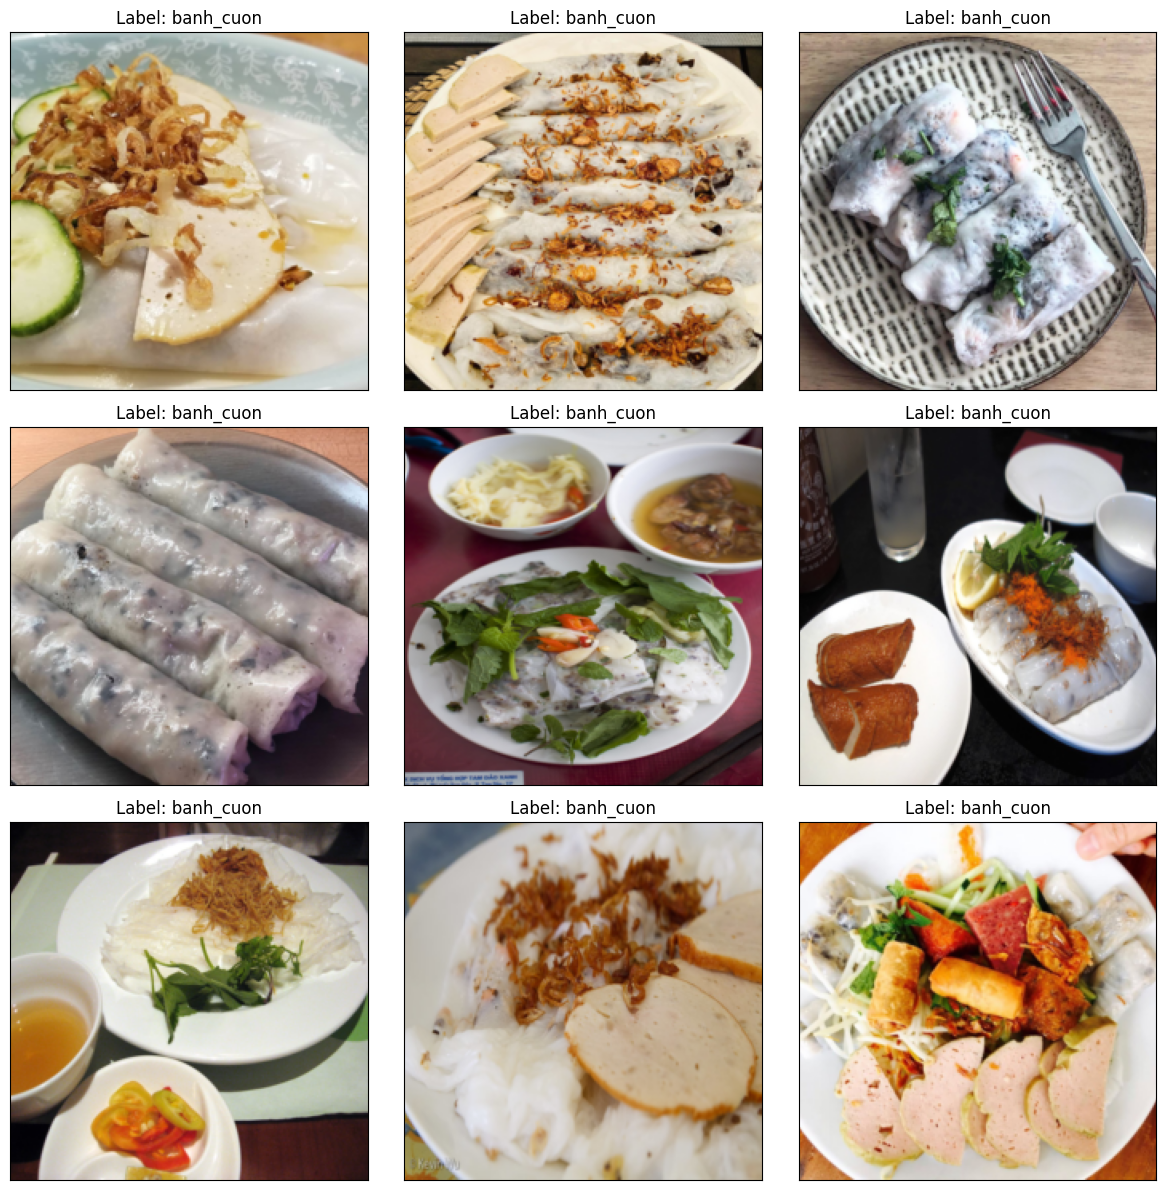

In [9]:
plot_random_batch_images(valid_loader, classes, num_images_to_show=9, figsize=(12, 12))

Displaying 9 random images...


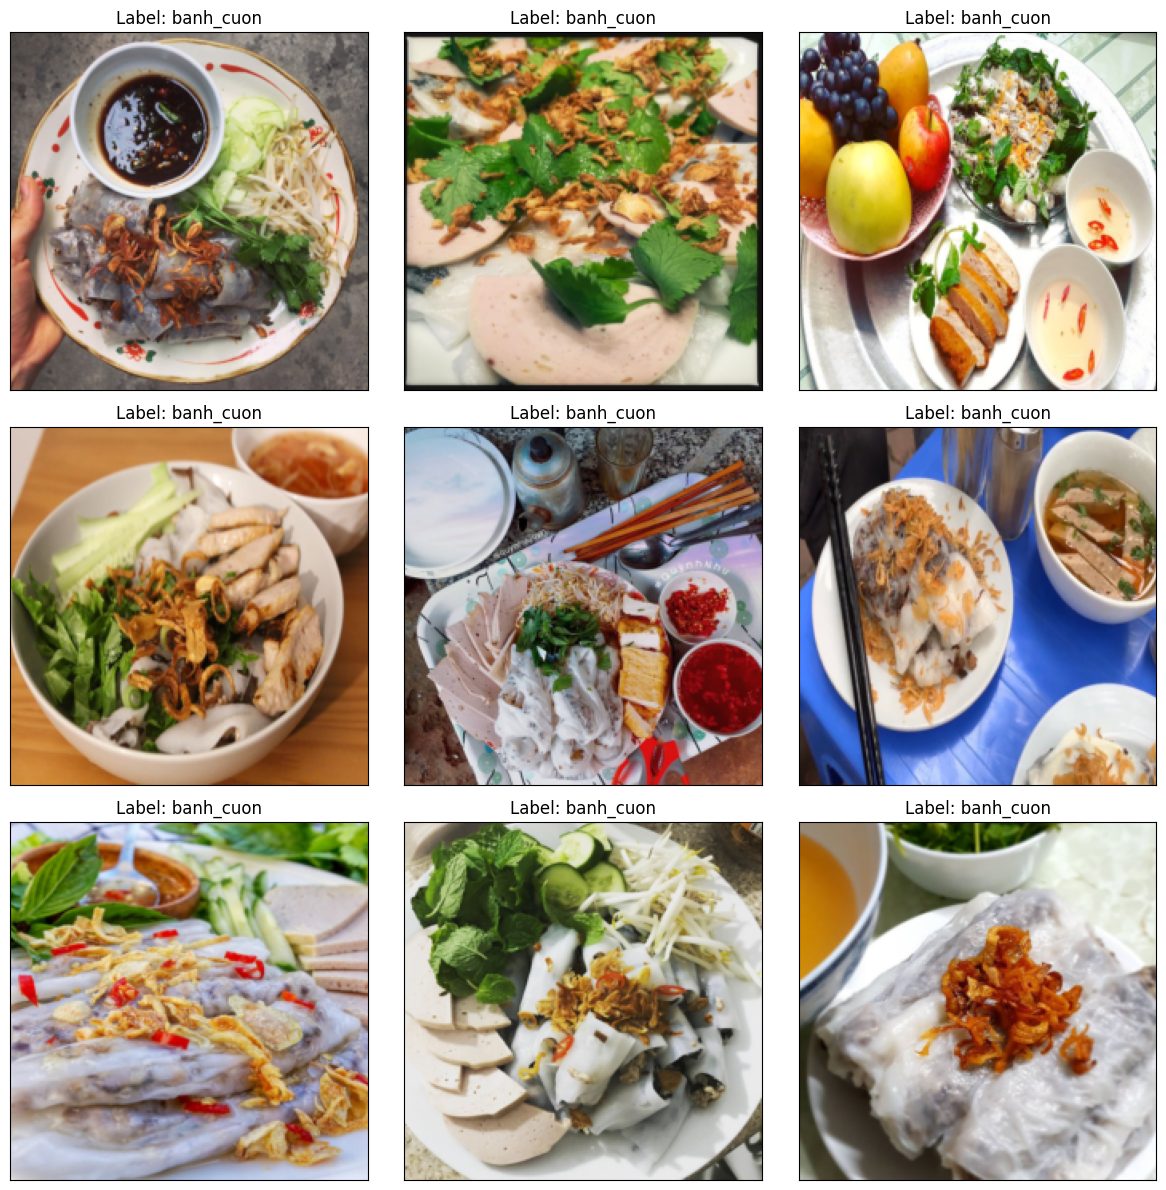

In [10]:
plot_random_batch_images(test_loader, classes, num_images_to_show=9, figsize=(12, 12))

### **Model**

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [36]:
class VNFOODs(nn.Module):
    """
    PyTorch implementation of the Keras Sequential Model using MobileNetV2 as base.
    Input: 3 x 224 x 224
    Output: num_classes (softmax)
    """
    def __init__(self):
        super(VNFOODs, self).__init__()
        base_model = models.mobilenet_v2(
            weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

        for param in base_model.parameters():
            param.requires_grad = False
            
        self.feature_extractor = base_model.features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(base_model.last_channel, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [38]:
num_classes = len(classes)
model = VNFOODs().to(device)

print(model)

VNFOODs(
  (feature_extractor): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96,

### **Training**

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [40]:
# Training one epoch
def train_epoch(model,
                dataloader,
                criterion, 
                optimizer, 
                device):
    model.train()
    running_loss = 0.0
    running_corrects = 0.0
    total_samples = 0

    for inputs, labels in tqdm(dataloader, desc='Training'):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

    train_loss = running_loss / total_samples
    train_acc = running_corrects.double() / total_samples

    return train_loss, train_acc

In [41]:
# Validate one epoch
def validate_epoch(model,
                   dataloader, 
                   criterion, 
                   device):
    model.eval()
    valid_loss = 0.0
    val_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs =  model(inputs)
            loss = criterion(outputs, labels)

            valid_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    val_loss = valid_loss / total_samples
    val_acc = val_corrects.double() / total_samples

    return val_loss, val_acc

In [42]:
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

In [43]:
NUM_EPOCHS = 10

In [44]:
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, valid_loader, criterion, device)
    
    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc.item())
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc.item())

    print(f"[{epoch+1:2d}/{NUM_EPOCHS}] "
          f"train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - "
          f"val_acc: {val_acc:.4f} - val_loss: {val_loss:.4f}")

Training: 100%|██████████| 72/72 [01:03<00:00,  1.14it/s]


[ 1/10] train_acc: 0.8215 - train_loss: 0.7558 - val_acc: 0.9024 - val_loss: 0.6587


Training: 100%|██████████| 72/72 [01:06<00:00,  1.09it/s]


[ 2/10] train_acc: 0.9016 - train_loss: 0.6602 - val_acc: 0.8933 - val_loss: 0.6630


Training: 100%|██████████| 72/72 [01:05<00:00,  1.10it/s]


[ 3/10] train_acc: 0.9155 - train_loss: 0.6411 - val_acc: 0.9116 - val_loss: 0.6351


Training: 100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


[ 4/10] train_acc: 0.9221 - train_loss: 0.6316 - val_acc: 0.9299 - val_loss: 0.6272


Training: 100%|██████████| 72/72 [01:05<00:00,  1.09it/s]


[ 5/10] train_acc: 0.9308 - train_loss: 0.6282 - val_acc: 0.9024 - val_loss: 0.6468


Training: 100%|██████████| 72/72 [01:03<00:00,  1.14it/s]


[ 6/10] train_acc: 0.9264 - train_loss: 0.6244 - val_acc: 0.9360 - val_loss: 0.6269


Training: 100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


[ 7/10] train_acc: 0.9234 - train_loss: 0.6277 - val_acc: 0.9329 - val_loss: 0.6188


Training: 100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


[ 8/10] train_acc: 0.9247 - train_loss: 0.6261 - val_acc: 0.9329 - val_loss: 0.6178


Training: 100%|██████████| 72/72 [01:19<00:00,  1.10s/it]


[ 9/10] train_acc: 0.9330 - train_loss: 0.6200 - val_acc: 0.9299 - val_loss: 0.6174


Training: 100%|██████████| 72/72 [01:07<00:00,  1.07it/s]


[10/10] train_acc: 0.9303 - train_loss: 0.6208 - val_acc: 0.9360 - val_loss: 0.6165


### **Fine Tuning**

In [45]:
for i, module in enumerate(model.feature_extractor):
    if i >= 12:
        for param in module.parameters():
            param.requires_grad = True

In [46]:
fine_tune_optimizer = optim.Adam(model.parameters(), lr=1e-5)
fine_tune_history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}

In [47]:
FINE_TUNING_EPOCHS = 10
total_epochs = NUM_EPOCHS + FINE_TUNING_EPOCHS

In [48]:
for epoch in range(NUM_EPOCHS + 1, total_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, fine_tune_optimizer, device)
    val_loss, val_acc = validate_epoch(model, valid_loader, criterion, device)
    
    # Store history for plotting later
    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc.item())
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc.item())

    print(f"[{epoch:2d}/{total_epochs} - Fine-Tune] "
          f"train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - "
          f"val_acc: {val_acc:.4f} - val_loss: {val_loss:.4f}")

Training: 100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


[11/20 - Fine-Tune] train_acc: 0.9395 - train_loss: 0.6117 - val_acc: 0.9390 - val_loss: 0.6139


Training: 100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


[12/20 - Fine-Tune] train_acc: 0.9508 - train_loss: 0.6021 - val_acc: 0.9482 - val_loss: 0.6091


Training: 100%|██████████| 72/72 [01:05<00:00,  1.10it/s]


[13/20 - Fine-Tune] train_acc: 0.9530 - train_loss: 0.5988 - val_acc: 0.9482 - val_loss: 0.6044


Training: 100%|██████████| 72/72 [01:31<00:00,  1.27s/it]


[14/20 - Fine-Tune] train_acc: 0.9639 - train_loss: 0.5881 - val_acc: 0.9482 - val_loss: 0.6045


Training: 100%|██████████| 72/72 [01:35<00:00,  1.32s/it]


[15/20 - Fine-Tune] train_acc: 0.9573 - train_loss: 0.5950 - val_acc: 0.9390 - val_loss: 0.6083


Training: 100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


[16/20 - Fine-Tune] train_acc: 0.9656 - train_loss: 0.5873 - val_acc: 0.9604 - val_loss: 0.5957


Training: 100%|██████████| 72/72 [01:03<00:00,  1.13it/s]


[17/20 - Fine-Tune] train_acc: 0.9539 - train_loss: 0.5957 - val_acc: 0.9604 - val_loss: 0.5916


Training: 100%|██████████| 72/72 [01:05<00:00,  1.10it/s]


[18/20 - Fine-Tune] train_acc: 0.9647 - train_loss: 0.5885 - val_acc: 0.9604 - val_loss: 0.5921


Training: 100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


[19/20 - Fine-Tune] train_acc: 0.9630 - train_loss: 0.5865 - val_acc: 0.9634 - val_loss: 0.5882


Training: 100%|██████████| 72/72 [01:07<00:00,  1.06it/s]


[20/20 - Fine-Tune] train_acc: 0.9660 - train_loss: 0.5845 - val_acc: 0.9634 - val_loss: 0.5883


In [49]:
model.eval()
y_true = []
y_pred_list = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        
        outputs = model(inputs)
        
        # Get predicted class index
        _, y_pred = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred_list.extend(y_pred.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred_list)

Testing: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it]


In [50]:
print(f"Accuracy Score: {accuracy_score(y_true, y_pred):.4f}")

Accuracy Score: 0.9544


In [51]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

Classification Report:
              precision    recall  f1-score   support

   banh_cuon     0.9270    0.9474    0.9371       228
     banh_mi     0.9844    0.9403    0.9618       268
         pho     0.9467    0.9877    0.9668       162

    accuracy                         0.9544       658
   macro avg     0.9527    0.9584    0.9552       658
weighted avg     0.9552    0.9544    0.9545       658



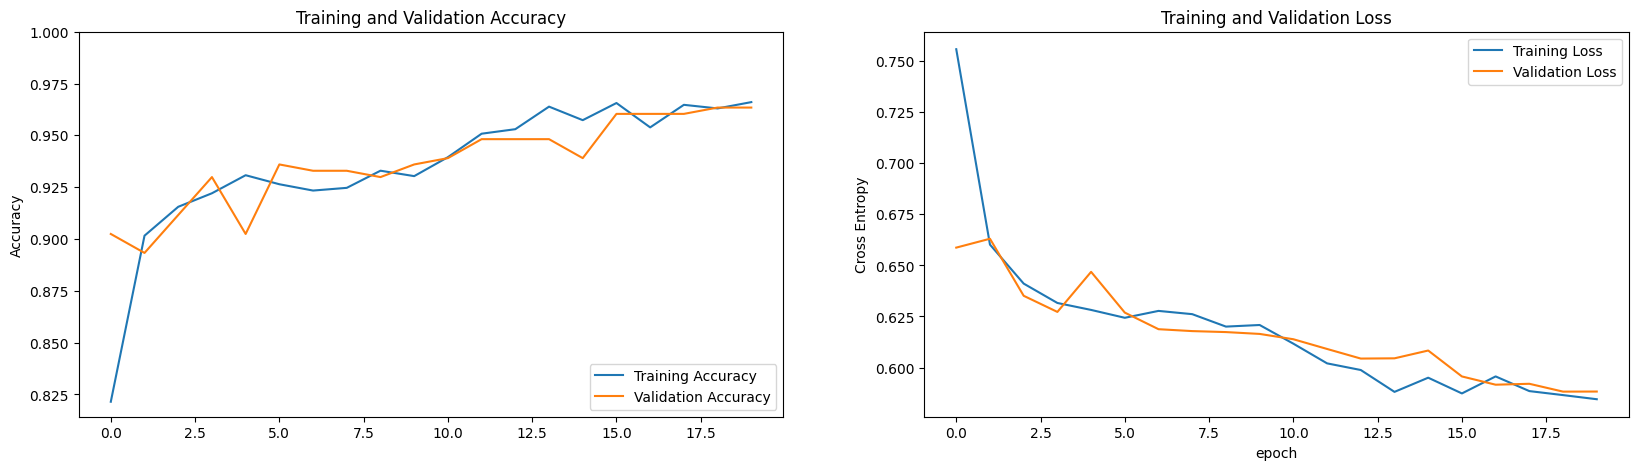

In [52]:
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [53]:
torch.save(model, 'VNFOOD_model_weights.pth')

In [54]:
ROOT_DIR = os.path.abspath(".")
MODEL_WEIGHT_PATH = os.path.join(ROOT_DIR, 'VNFOOD_model_weights.pth')

In [55]:
def load_model():
    model = VNFOODs() 
    state_dict = torch.load(MODEL_WEIGHT_PATH, weights_only=False)
    model.load_state_dict(state_dict)
    model.eval()
    return model